In [11]:
from tree import Mbtree, Mbtree_GUI

mbtree = Mbtree.load("../data/aidata")
Mbtree_GUI(mbtree)

In [12]:
%%timeit
from util import load_bestmoves

load_bestmoves("../data/bestmoves_by_board.dat")

5.48 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
from tree import Node

def __init__(self, mb, parent=None, depth=0, bestmoves_by_board=None):
    self.id = Node.count
    Node.count += 1
    self.mb = mb
    self.parent = parent
    self.depth = depth
    self.children = []
    self.children_by_move = {}   
    if bestmoves_by_board is not None:
        self.bestmoves = bestmoves_by_board[self.mb.board_to_str()]
        
Node.__init__ = __init__

In [14]:
from copy import deepcopy

def calc_children(self, bestmoves_by_board=None):
    self.children = []
    for x, y in self.mb.calc_legal_moves():
        childmb = deepcopy(self.mb)
        childmb.move(x, y)
        self.insert(Node(childmb, parent=self, depth=self.depth + 1,
                         bestmoves_by_board=bestmoves_by_board))
        
Node.calc_children = calc_children

In [15]:
from marubatsu import Marubatsu

def create_subtree(self):
    bestmoves_by_board = self.subtree["bestmoves_by_board"]
    self.root = Node(Marubatsu(), bestmoves_by_board=bestmoves_by_board)
    
    depth = 0
    nodelist = [self.root]
    centermb = self.subtree["centermb"]
    centerdepth = centermb.move_count
    records = centermb.records
    maxdepth = self.subtree["maxdepth"]
    while len(nodelist) > 0:
        childnodelist = []
        for node in nodelist:
            if depth < centerdepth - 1:
                childmb = deepcopy(node.mb)
                x, y = records[depth + 1]
                childmb.move(x, y)
                childnode = Node(childmb, parent=node, depth=depth+1, 
                                 bestmoves_by_board=bestmoves_by_board)   
                node.insert(childnode)
                childnodelist.append(childnode)
            elif depth < maxdepth:
                node.calc_children(bestmoves_by_board=bestmoves_by_board)                   
                if depth == centerdepth - 1:
                    for move, childnode in node.children_by_move.items():
                        if move == records[depth + 1]:
                            self.centernode = childnode
                            childnodelist.append(self.centernode)
                        else:
                            if childnode.mb.status == Marubatsu.PLAYING:
                                childnode.children.append(None)
                else:
                    childnodelist += node.children
            else:
                if node.mb.status == Marubatsu.PLAYING:
                    childmb = deepcopy(node.mb)
                    board_str = node.mb.board_to_str()               
                    x, y = bestmoves_by_board[board_str][0]
                    childmb.move(x, y)
                    childnode = Node(childmb, parent=node, depth=depth+1, 
                                     bestmoves_by_board=bestmoves_by_board)   
                    node.insert(childnode)
                    childnodelist.append(childnode)
        nodelist = childnodelist
        depth += 1

Mbtree.create_subtree = create_subtree

TypeError: '>' not supported between instances of 'NoneType' and 'int'

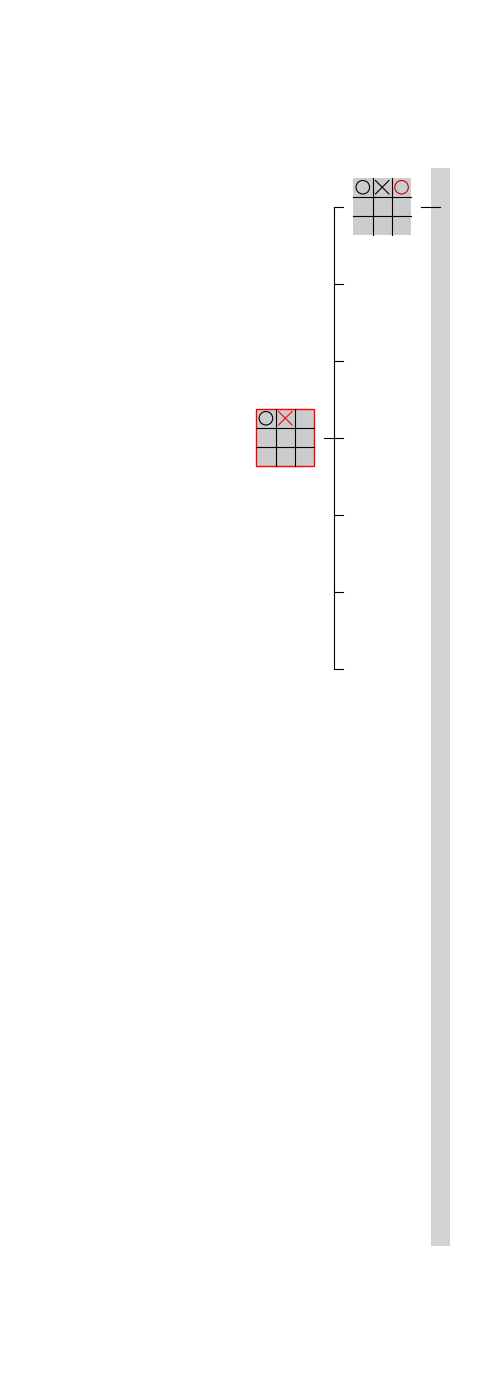

In [16]:
from util import load_bestmoves

mb = Marubatsu()
mb.move(0, 0)
mb.move(1, 0)
maxdepth = 3
bestmoves_by_board = load_bestmoves("../data/bestmoves_by_board.dat")
subtree = Mbtree(subtree={"centermb": mb, "maxdepth": maxdepth, 
                          "bestmoves_by_board": bestmoves_by_board})
centernode = subtree.centernode
subtree.draw_subtree(centernode=centernode, selectednode=centernode, maxdepth=maxdepth,
                     show_bestmove=True)

In [17]:
from marubatsu import Marubatsu_GUI
import matplotlib.patches as patches

def draw_board(ax, mb, show_result=False, score=None, bc=None, bw=1, darkness=0, dx=0, dy=0, lw=2):
    # 結果によってゲーム盤の背景色を変更する
    if show_result:
        if score is None and mb.status == Marubatsu.PLAYING:
            bgcolor = "white"
        elif (score is not None and score > 0) or mb.status == Marubatsu.CIRCLE:
            bgcolor = "lightcyan"
        elif (score is not None and score < 0) or mb.status == Marubatsu.CROSS:
            bgcolor = "lavenderblush"
        else:
            bgcolor = "lightyellow"      
            
        rect = patches.Rectangle(xy=(dx, dy), width=mb.BOARD_SIZE,
                                height=mb.BOARD_SIZE, fc=bgcolor)
        ax.add_patch(rect)

    # ゲーム盤の枠を描画する
    for i in range(1, mb.BOARD_SIZE):
        ax.plot([dx, dx + mb.BOARD_SIZE], [dy + i, dy + i], c="k", lw=lw) # 横方向の枠線
        ax.plot([dx + i, dx + i], [dy, dy + mb.BOARD_SIZE], c="k", lw=lw) # 縦方向の枠線

    # ゲーム盤のマークを描画する
    for y in range(mb.BOARD_SIZE):
        for x in range(mb.BOARD_SIZE):
            color = "red" if (x, y) == mb.last_move else "black"
            Marubatsu_GUI.draw_mark(ax, dx + x, dy + y, mb.board[x][y], color, lw=lw)

    # darkness 0 より大きい場合は、半透明の黒い正方形を描画して暗くする
    if darkness > 0:
        ax.add_artist(patches.Rectangle(xy=(dx, dy), width=mb.BOARD_SIZE,
                                        height=mb.BOARD_SIZE, fc="black", alpha=darkness))

    # bc が None でない場合はその色で bw の太さで外枠を描画する
    if bc is not None:
        frame = patches.Rectangle(xy=(dx, dy), width=mb.BOARD_SIZE,
                                height=mb.BOARD_SIZE, ec=bc, fill=False, lw=bw)
        ax.add_patch(frame)

Marubatsu_GUI.draw_board = draw_board

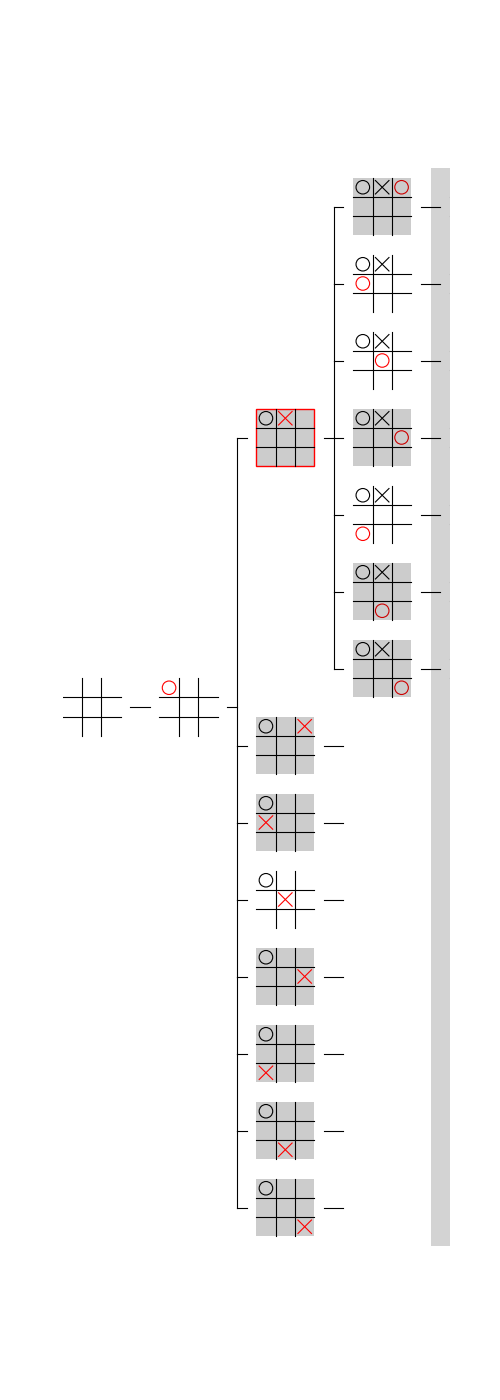

In [18]:
subtree = Mbtree(subtree={"centermb": mb, "maxdepth": maxdepth, 
                          "bestmoves_by_board": bestmoves_by_board})
centernode = subtree.centernode
subtree.draw_subtree(centernode=centernode, selectednode=centernode, maxdepth=maxdepth,
                     show_bestmove=True)

In [19]:
import matplotlib.pyplot as plt

def draw_subtree(self, centernode=None, selectednode=None, ax=None, anim_frame=None,
                    isscore=False, show_bestmove=False, show_score=True, size=0.25, lw=0.8, maxdepth=2):

    
    def calc_darkness(node):
        """ノードを表示する暗さを計算して返す."""
        
        if show_bestmove:
            if node.parent is None:
                return 0
            elif node.mb.last_move in node.parent.bestmoves:
                return 0
            else:
                return 0.2
            
        if anim_frame is None:
            return 0
        index = node.score_index if isscore else node.id
        return 0.5 if index > anim_frame else 0
    
    self.nodes_by_rect = {}

    if centernode is None:
        centernode = self.root
    self.calc_node_height(N=centernode, maxdepth=maxdepth)
    if show_bestmove:
        width = 5 * 10
    else:
        width = 5 * (maxdepth + 1)
    height = centernode.height
    parent = centernode.parent
    if parent is not None:
        height += (len(parent.children) - 1) * 4
        parent.height = height
    if ax is None:
        fig, ax = plt.subplots(figsize=(width * size, height * size))
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)   
        ax.invert_yaxis()
        ax.axis("off")        
    
    if show_bestmove:
        bestx = 5 * maxdepth + 4
        bestwidth = 50 - bestx
        ax.add_artist(patches.Rectangle(xy=(bestx, -1), width=bestwidth,
                                        height=height + 1, fc="lightgray"))
    
    nodelist = [centernode]
    depth = centernode.depth
    while len(nodelist) > 0 and depth <= maxdepth:        
        dy = 0
        if parent is not None:
            dy = parent.children.index(centernode) * 4
        childnodelist = []
        for node in nodelist:
            if node is None:
                dy += 4
                childnodelist.append(None)
            else:
                dx = 5 * node.depth
                emphasize = node is selectednode
                darkness = calc_darkness(node)
                rect = node.draw_node(ax=ax, maxdepth=maxdepth, emphasize=emphasize, darkness=darkness,
                                    show_score=show_score, size=size, lw=lw, dx=dx, dy=dy)
                self.nodes_by_rect[rect] = node
                if show_bestmove and depth == maxdepth:
                    bestnode = node
                    while len(bestnode.bestmoves) > 0:
                        bestmove = bestnode.bestmoves[0]
                        bestnode = bestnode.children_by_move[bestmove]
                        dx = 5 * bestnode.depth
                        bestnode.height = 4
                        rect = bestnode.draw_node(ax=ax, maxdepth=bestnode.depth, emphasize=emphasize,
                                                show_score=show_score, size=size, lw=lw, dx=dx, dy=dy)
                        self.nodes_by_rect[rect] = bestnode                                          
                    
                dy += node.height
                if len(node.children) > 0:  
                    childnodelist += node.children
                else:
                    childnodelist.append(None)
        depth += 1
        nodelist = childnodelist
        
    if parent is not None:
        dy = 0
        for sibling in parent.children:
            if sibling is not centernode:
                sibling.height = 4
                dx = 5 * sibling.depth
                darkness = calc_darkness(sibling)
                rect = sibling.draw_node(ax, maxdepth=sibling.depth, size=size, darkness=darkness,
                                        show_score=show_score, lw=lw, dx=dx, dy=dy)
                self.nodes_by_rect[rect] = sibling
            dy += sibling.height
        dx = 5 * parent.depth
        darkness = calc_darkness(parent)
        rect = parent.draw_node(ax, maxdepth=maxdepth, darkness=darkness, 
                                show_score=show_score, size=size, lw=lw, dx=dx, dy=0)
        self.nodes_by_rect[rect] = parent
    
        node = parent
        while node.parent is not None:
            node = node.parent
            node.height = height
            dx = 5 * node.depth
            darkness = calc_darkness(node)
            rect = node.draw_node(ax, maxdepth=node.depth, darkness=darkness,
                                show_score=show_score, size=size, lw=lw, dx=dx, dy=0)
            self.nodes_by_rect[rect] = node
            
Mbtree.draw_subtree = draw_subtree

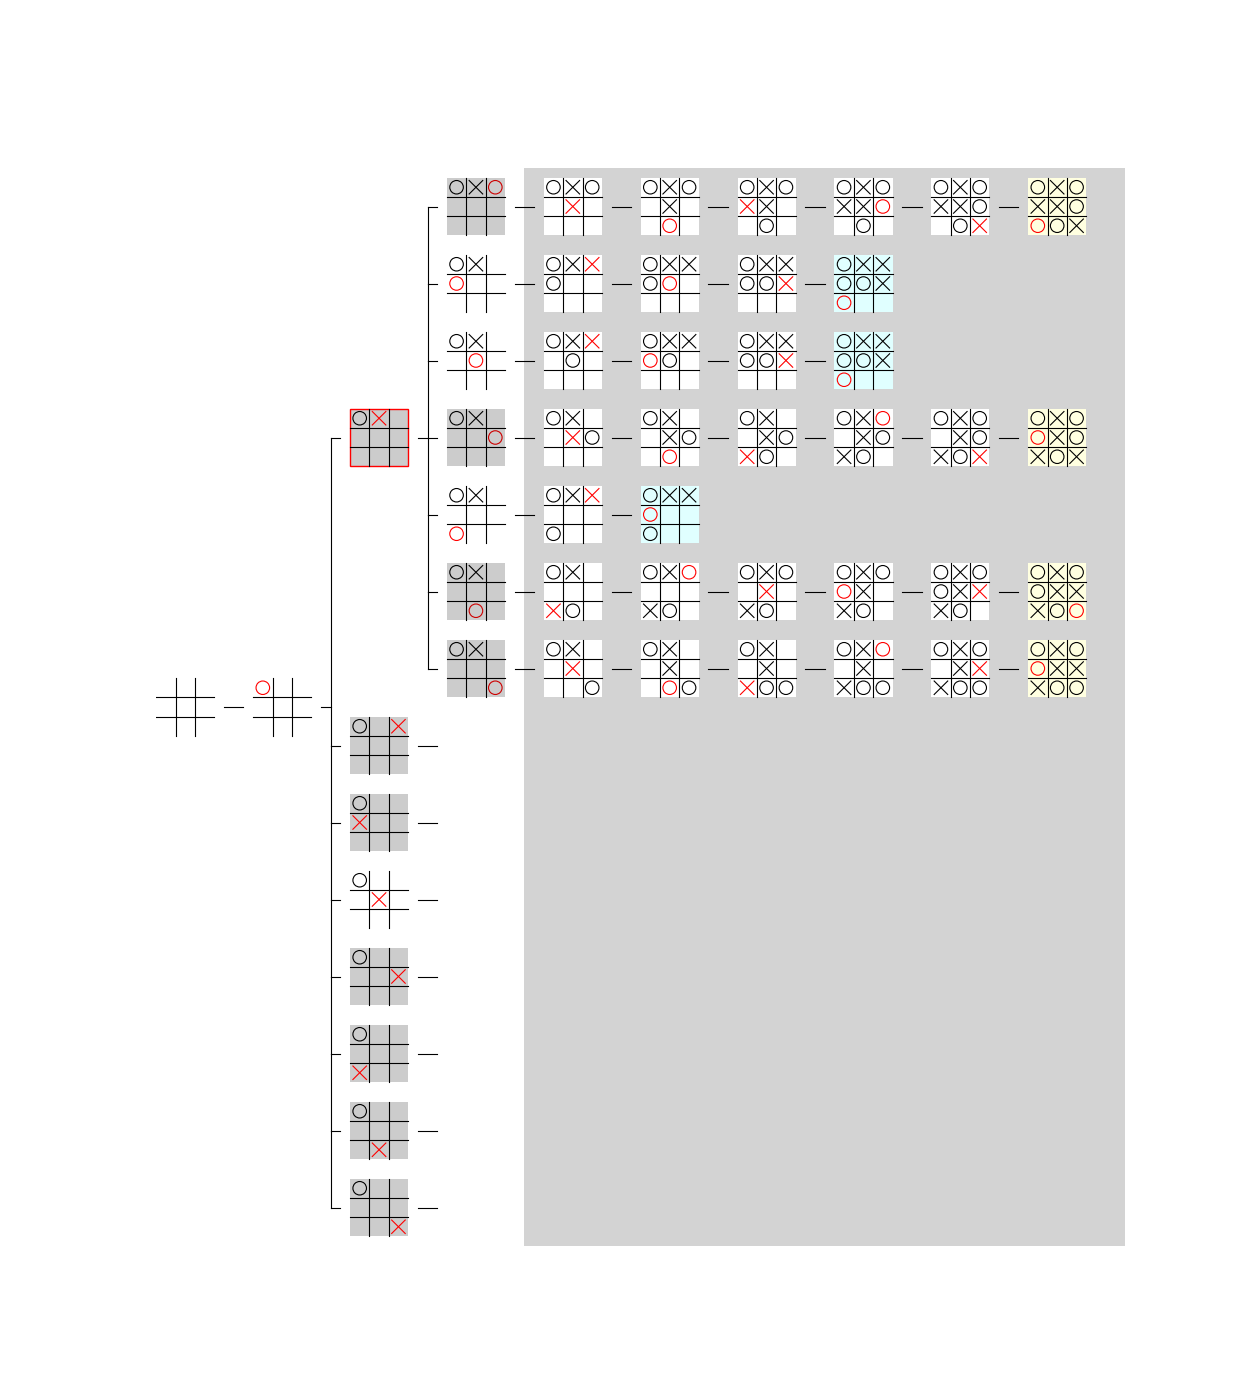

In [20]:
subtree = Mbtree(subtree={"centermb": mb, "maxdepth": maxdepth, 
                          "bestmoves_by_board": bestmoves_by_board})
centernode = subtree.centernode
subtree.draw_subtree(centernode=centernode, selectednode=centernode, maxdepth=maxdepth,
                     show_bestmove=True)

In [21]:
def create_subtree(self):
    bestmoves_by_board = self.subtree["bestmoves_by_board"]
    self.root = Node(Marubatsu(), bestmoves_by_board=bestmoves_by_board)
    
    depth = 0
    nodelist = [self.root]
    centermb = self.subtree["centermb"]
    centerdepth = centermb.move_count
    records = centermb.records
    maxdepth = self.subtree["maxdepth"]
    while len(nodelist) > 0:
        childnodelist = []
        for node in nodelist:
            if depth < centerdepth - 1:
                childmb = deepcopy(node.mb)
                x, y = records[depth + 1]
                childmb.move(x, y)
                childnode = Node(childmb, parent=node, depth=depth+1, 
                                 bestmoves_by_board=bestmoves_by_board)   
                node.insert(childnode)
                childnodelist.append(childnode)
            elif depth < maxdepth:
                node.calc_children(bestmoves_by_board=bestmoves_by_board)                   
                if depth == centerdepth - 1:
                    for move, childnode in node.children_by_move.items():
                        if move == records[depth + 1]:
                            self.centernode = childnode
                            childnodelist.append(self.centernode)
                        else:
                            if childnode.mb.status == Marubatsu.PLAYING:
                                childnode.children.append(None)
                else:
                    childnodelist += node.children
            else:
                if node.mb.status == Marubatsu.PLAYING:
                    childmb = deepcopy(node.mb)
                    board_str = node.mb.board_to_str()               
                    x, y = bestmoves_by_board[board_str][0]
                    childmb.move(x, y)
                    childnode = Node(childmb, parent=node, depth=depth+1, 
                                     bestmoves_by_board=bestmoves_by_board)   
                    node.insert(childnode)
                    childnodelist.append(childnode)
        nodelist = childnodelist
        depth += 1
        
    selectedmb = self.subtree["selectedmb"]
    self.selectednode = self.root
    for move in selectedmb.records[1:]:
        self.selectednode = self.selectednode.children_by_move[move]

Mbtree.create_subtree = create_subtree

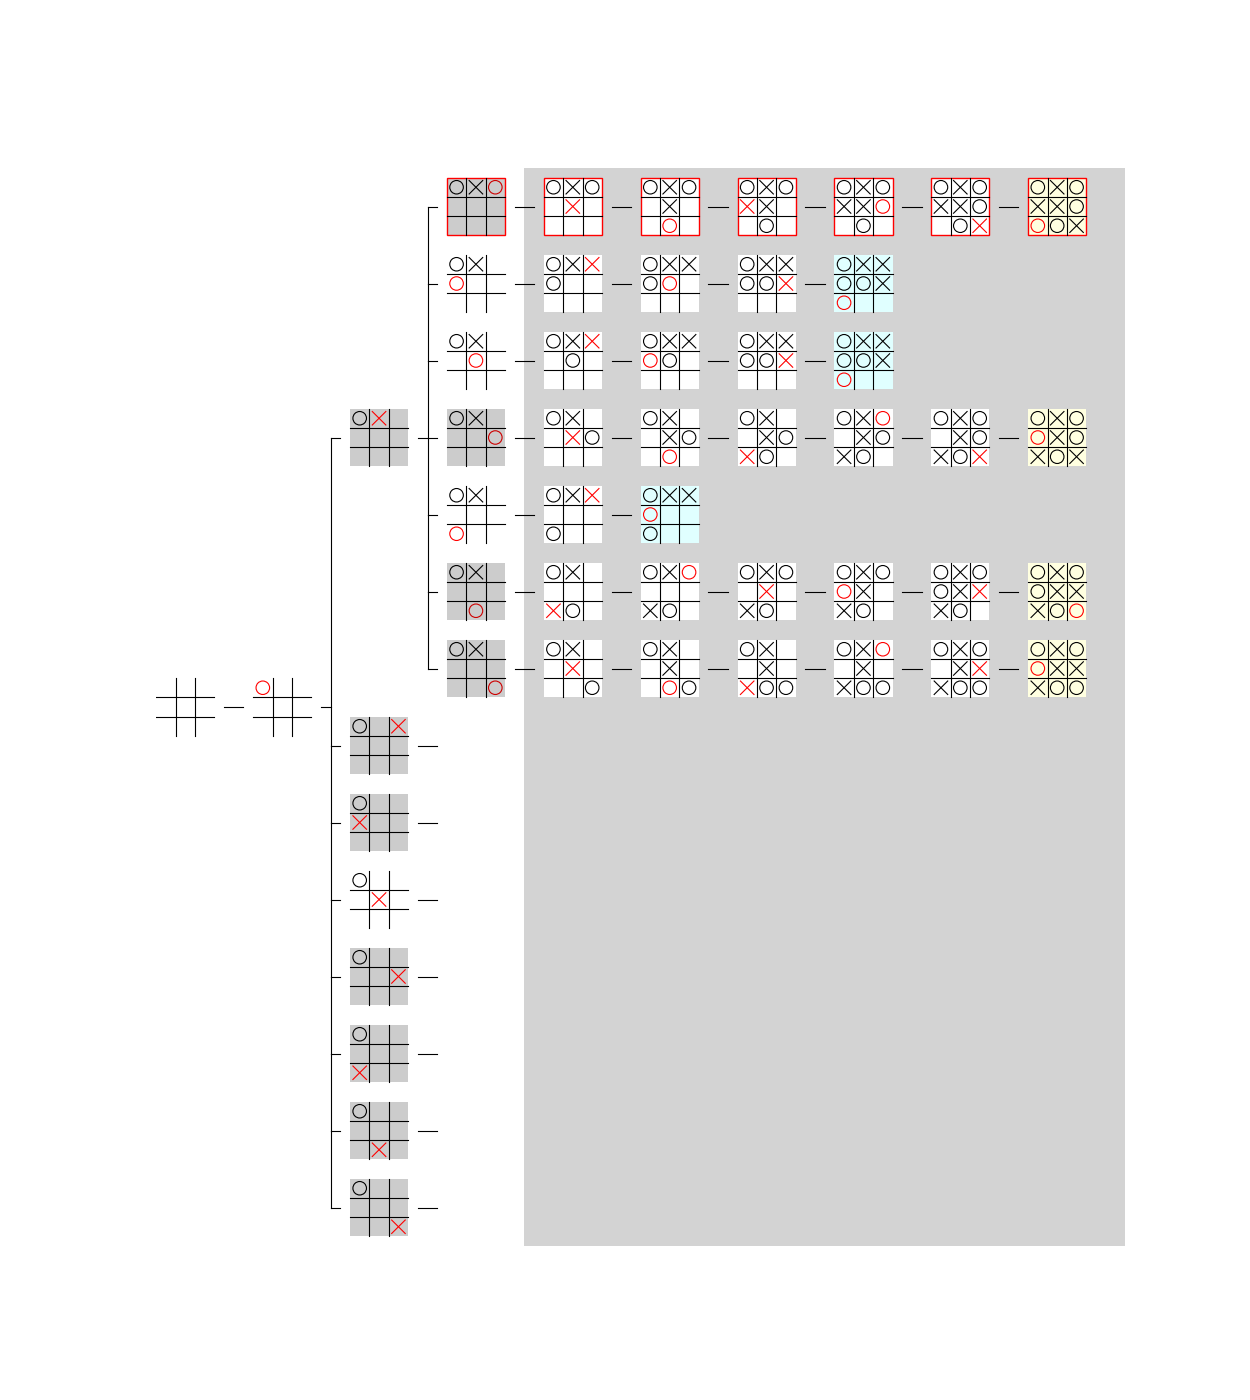

In [22]:
mb2 = Marubatsu()
mb2.move(0, 0)
mb2.move(1, 0)
mb2.move(2, 0)
subtree = Mbtree(subtree={"centermb": mb, "selectedmb": mb2, "maxdepth": maxdepth, 
                          "bestmoves_by_board": bestmoves_by_board})
centernode = subtree.centernode
selectednode = subtree.selectednode
subtree.draw_subtree(centernode=centernode, selectednode=selectednode, maxdepth=maxdepth,
                     show_bestmove=True)

In [23]:
def draw_subtree(self, centernode=None, selectednode=None, ax=None, anim_frame=None,
                    isscore=False, show_bestmove=False, show_score=True, size=0.25, lw=0.8, maxdepth=2):
    def calc_darkness(node):
        """ノードを表示する暗さを計算して返す."""
        
        if show_bestmove:
            if node.parent is None:
                return 0
            elif node.mb.last_move in node.parent.bestmoves:
                return 0
            else:
                return 0.2
            
        if anim_frame is None:
            return 0
        index = node.score_index if isscore else node.id
        return 0.5 if index > anim_frame else 0
    
    self.nodes_by_rect = {}

    if centernode is None:
        centernode = self.root
    self.calc_node_height(N=centernode, maxdepth=maxdepth)
    if show_bestmove:
        width = 5 * 10
    else:
        width = 5 * (maxdepth + 1)
    height = centernode.height
    parent = centernode.parent
    if parent is not None:
        height += (len(parent.children) - 1) * 4
        parent.height = height
    if ax is None:
        fig, ax = plt.subplots(figsize=(width * size, height * size))
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)   
        ax.invert_yaxis()
        ax.axis("off")        
    
    if show_bestmove:
        bestx = 5 * maxdepth + 4
        bestwidth = 50 - bestx
        ax.add_artist(patches.Rectangle(xy=(bestx, -1), width=bestwidth,
                                        height=height + 1, fc="lightgray"))
    
    nodelist = [centernode]
    depth = centernode.depth
    while len(nodelist) > 0 and depth <= maxdepth:        
        dy = 0
        if parent is not None:
            dy = parent.children.index(centernode) * 4
        childnodelist = []
        for node in nodelist:
            if node is None:
                dy += 4
                childnodelist.append(None)
            else:
                dx = 5 * node.depth
                emphasize = node is selectednode
                darkness = calc_darkness(node)
                rect = node.draw_node(ax=ax, maxdepth=maxdepth, emphasize=emphasize, darkness=darkness,
                                    show_score=show_score, size=size, lw=lw, dx=dx, dy=dy)
                self.nodes_by_rect[rect] = node
                if show_bestmove and depth == maxdepth:
                    bestnode = node
                    while len(bestnode.bestmoves) > 0:
                        bestmove = bestnode.bestmoves[0]
                        bestnode = bestnode.children_by_move[bestmove]
                        dx = 5 * bestnode.depth
                        bestnode.height = 4
                        emphasize = bestnode is selectednode
                        rect = bestnode.draw_node(ax=ax, maxdepth=bestnode.depth, emphasize=emphasize,
                                                show_score=show_score, size=size, lw=lw, dx=dx, dy=dy)
                        self.nodes_by_rect[rect] = bestnode                                          
                    
                dy += node.height
                if len(node.children) > 0:  
                    childnodelist += node.children
                else:
                    childnodelist.append(None)
        depth += 1
        nodelist = childnodelist
        
    if parent is not None:
        dy = 0
        for sibling in parent.children:
            if sibling is not centernode:
                sibling.height = 4
                dx = 5 * sibling.depth
                darkness = calc_darkness(sibling)
                rect = sibling.draw_node(ax, maxdepth=sibling.depth, size=size, darkness=darkness,
                                        show_score=show_score, lw=lw, dx=dx, dy=dy)
                self.nodes_by_rect[rect] = sibling
            dy += sibling.height
        dx = 5 * parent.depth
        darkness = calc_darkness(parent)
        rect = parent.draw_node(ax, maxdepth=maxdepth, darkness=darkness, 
                                show_score=show_score, size=size, lw=lw, dx=dx, dy=0)
        self.nodes_by_rect[rect] = parent
    
        node = parent
        while node.parent is not None:
            node = node.parent
            node.height = height
            dx = 5 * node.depth
            darkness = calc_darkness(node)
            rect = node.draw_node(ax, maxdepth=node.depth, darkness=darkness,
                                show_score=show_score, size=size, lw=lw, dx=dx, dy=0)
            self.nodes_by_rect[rect] = node
            
Mbtree.draw_subtree = draw_subtree

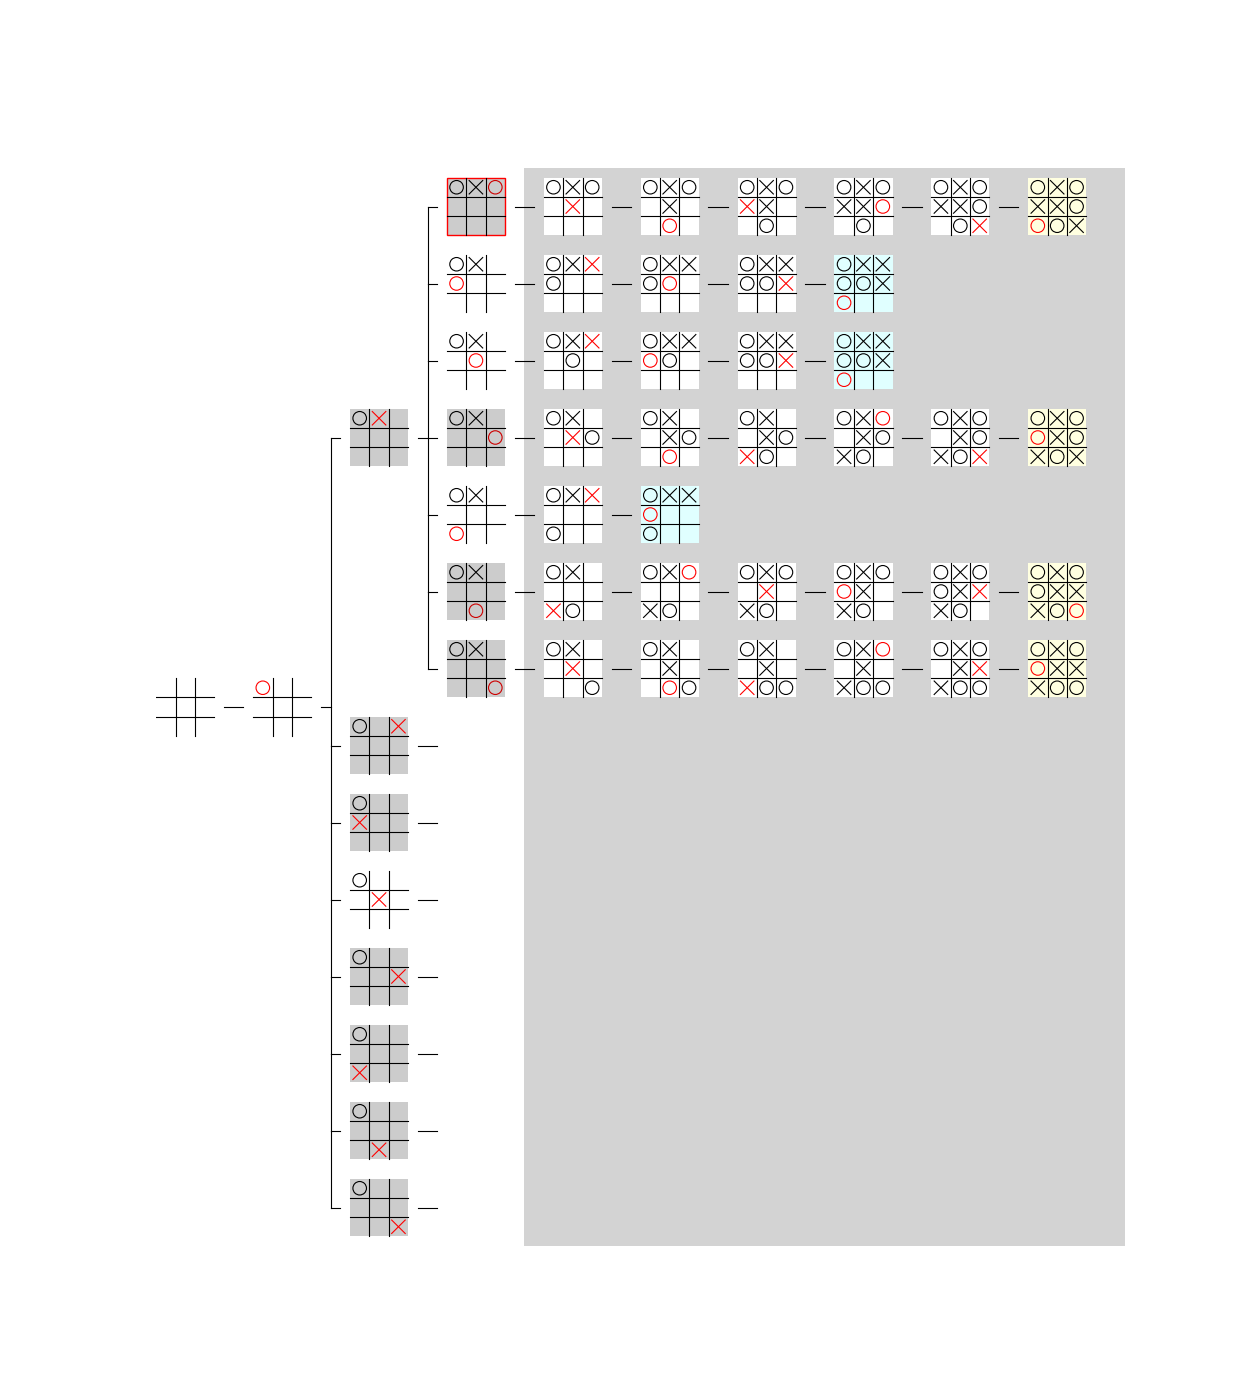

In [24]:
subtree = Mbtree(subtree={"centermb": mb, "selectedmb": mb2, "maxdepth": maxdepth, 
                          "bestmoves_by_board": bestmoves_by_board})
centernode = subtree.centernode
selectednode = subtree.selectednode
subtree.draw_subtree(centernode=centernode, selectednode=selectednode, maxdepth=maxdepth,
                     show_bestmove=True)

In [25]:
%%timeit
Mbtree(subtree={"centermb": mb, "selectedmb": mb2, "maxdepth": maxdepth, 
                "bestmoves_by_board": bestmoves_by_board})

2.51 ms ± 84.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
